In [4]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpuNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/619.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/619.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/619.4 MB 1.4 MB/s eta 0:07:24
   ---------------------------------------- 1.0/619.4 MB 1.7 MB/s eta 0:06:09
   ---------------------------------------- 1.3/619.4 MB 1.7 MB/s eta 0:06:09
   ---------------------------------------- 1.6/619.4 MB 1.7 MB/s eta 0:06:02
   ---------------------------------------- 1.8/619.4 MB 1.5 MB/s eta 0:06:45
   ---------------------------------------- 1.8/619.4 MB 1.5 MB/s eta 0:06:45
   ---------------------------------------- 2.1/619.4 MB 1.3 MB/s eta 0:07:43
   ---------------------------------------- 2.4/619.4 MB 1.2 MB/s eta 0:08:17
   ---------------------------------------- 2.6/619.4 MB 1.2 MB/s eta 0:08:43
   ------------------------------

In [3]:
import torch
print(torch.__version__)


2.8.0+cpu


In [4]:
%pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.8.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.8.0+cpu.html
     ---------------------------------------- 0.0/769.7 kB ? eta -:--:--
     ------------------------- ------------ 524.3/769.7 kB 2.8 MB/s eta 0:00:01
     -------------------------------------- 769.7/769.7 kB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/525.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/525.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/525.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/525.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/525.7 kB ? eta -:--:--
     ------------------- -------------------- 262.1/525.7 kB ? eta -:--:--
     ------------------------------------ 525.7/525.7 kB 994.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   --------------------------- ------------ 0

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ------------------------
# 1. Load dataset
# ------------------------
train_df = pd.read_csv("training_data.csv")
test_df = pd.read_csv("test_data.csv")

# Drop extra unnamed columns if any
train_df = train_df.loc[:, ~train_df.columns.str.contains("^Unnamed")]
test_df = test_df.loc[:, ~test_df.columns.str.contains("^Unnamed")]

# ------------------------
# 2. Encode labels
# ------------------------
label_col = "prognosis"
le = LabelEncoder()
train_df[label_col] = le.fit_transform(train_df[label_col])
test_df[label_col] = le.transform(test_df[label_col])

# ------------------------
# 3. Train/Test Split
# ------------------------
X_train = train_df.drop(columns=[label_col])
y_train = train_df[label_col]
X_test = test_df.drop(columns=[label_col])
y_test = test_df[label_col]

# Ensure column alignment
common_cols = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_cols]
X_test  = X_test[common_cols]

# ------------------------
# 4. Dimensionality Reduction (SVD)
# ------------------------
svd = TruncatedSVD(n_components=100, random_state=42)
X_all = np.vstack([X_train, X_test])
X_reduced = svd.fit_transform(X_all)

X_train_red = X_reduced[:len(X_train)]
X_test_red  = X_reduced[len(X_train):]

# ------------------------
# 5. Graph Construction (patient-patient similarity)
# ------------------------
X_tensor = torch.tensor(X_reduced, dtype=torch.float)
y_tensor = torch.tensor(np.hstack([y_train, y_test]), dtype=torch.long)

# Cosine similarity
sim_matrix = cosine_similarity(X_reduced)
edge_index = torch.nonzero(torch.tensor(sim_matrix > 0.7, dtype=torch.bool), as_tuple=False).t().contiguous()

# Create PyG Data object
data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)

# ------------------------
# 6. Define Models
# ------------------------
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, dropout=0.3)
        self.conv2 = GATConv(hidden_channels*4, out_channels, heads=1)
    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# ------------------------
# 7. Training Utility with Metrics + Logging
# ------------------------
def train_and_eval(model, data, train_idx, test_idx, epochs=200, log_interval=20, name=""):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    print(f"\n🔹 Training {name} on sparse patient graph...")
    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[train_idx], data.y[train_idx])
        loss.backward()
        optimizer.step()
        if epoch % log_interval == 0:
            print(f"Epoch {epoch:03d}/{epochs} - Loss: {loss.item():.4f}")
    
    # Evaluation
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1).cpu().numpy()
    true = data.y.cpu().numpy()

    y_true, y_pred = true[test_idx], pred[test_idx]
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"{name} -> Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
    return acc, prec, rec, f1

# ------------------------
# 8. Train/Test Split Indices
# ------------------------
train_idx = torch.arange(len(X_train))
test_idx  = torch.arange(len(X_train), len(X_train) + len(X_test))

# ------------------------
# 9. Run Experiments + Summary
# ------------------------
results = {}
models = {
    "GCN": GCN(X_tensor.shape[1], 64, len(le.classes_)),
    "GraphSAGE": GraphSAGE(X_tensor.shape[1], 64, len(le.classes_)),
    "GAT": GAT(X_tensor.shape[1], 32, len(le.classes_))
}

for name, model in models.items():
    acc, prec, rec, f1 = train_and_eval(model, data, train_idx, test_idx, name=name)
    results[name] = (acc, prec, rec, f1)

print("\n=== Summary ===")
for name, (acc, prec, rec, f1) in results.items():
    print(f"{name:<10} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")



🔹 Training GCN on sparse patient graph...
Epoch 020/200 - Loss: 0.3615
Epoch 040/200 - Loss: 0.0701
Epoch 060/200 - Loss: 0.0363
Epoch 080/200 - Loss: 0.0258
Epoch 100/200 - Loss: 0.0236
Epoch 120/200 - Loss: 0.0236
Epoch 140/200 - Loss: 0.0236
Epoch 160/200 - Loss: 0.0233
Epoch 180/200 - Loss: 0.0229
Epoch 200/200 - Loss: 0.0225
GCN -> Acc: 0.9762, Prec: 0.9881, Rec: 0.9762, F1: 0.9762

🔹 Training GraphSAGE on sparse patient graph...
Epoch 020/200 - Loss: 0.0226
Epoch 040/200 - Loss: 0.0013
Epoch 060/200 - Loss: 0.0011
Epoch 080/200 - Loss: 0.0017
Epoch 100/200 - Loss: 0.0028
Epoch 120/200 - Loss: 0.0045
Epoch 140/200 - Loss: 0.0061
Epoch 160/200 - Loss: 0.0064
Epoch 180/200 - Loss: 0.0064
Epoch 200/200 - Loss: 0.0063
GraphSAGE -> Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000

🔹 Training GAT on sparse patient graph...
Epoch 020/200 - Loss: 0.0971
Epoch 040/200 - Loss: 0.0183
Epoch 060/200 - Loss: 0.0086
Epoch 080/200 - Loss: 0.0076
Epoch 100/200 - Loss: 0.0106
Epoch 120/200 - Lo

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ----------------------------------------------------
# 1. LOAD DATA
# ----------------------------------------------------
train_df = pd.read_csv("training_data.csv")
test_df = pd.read_csv("test_data.csv")

train_df = train_df.loc[:, ~train_df.columns.str.contains("^Unnamed")]
test_df  = test_df.loc[:, ~test_df.columns.str.contains("^Unnamed")]

label_col = "prognosis"

# ----------------------------------------------------
# 2. LABEL ENCODING
# ----------------------------------------------------
le = LabelEncoder()
train_df[label_col] = le.fit_transform(train_df[label_col])
test_df[label_col]  = le.transform(test_df[label_col])

X_train = train_df.drop(columns=[label_col])
y_train = train_df[label_col]

X_test  = test_df.drop(columns=[label_col])
y_test  = test_df[label_col]

# align cols
common_cols = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_cols]
X_test  = X_test[common_cols]

# ----------------------------------------------------
# 3. SVD (FIT ONLY ON TRAIN = NO LEAKAGE)
# ----------------------------------------------------
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_red = svd.fit_transform(X_train)
X_test_red  = svd.transform(X_test)

# ----------------------------------------------------
# 4. BUILD FULL GRAPH (train + test)
# ----------------------------------------------------
X_all = np.vstack([X_train_red, X_test_red])
y_all = np.hstack([y_train, y_test])

X_tensor = torch.tensor(X_all, dtype=torch.float)
y_tensor = torch.tensor(y_all, dtype=torch.long)

sim_matrix = cosine_similarity(X_all)
edge_index = torch.nonzero(torch.tensor(sim_matrix > 0.7, dtype=torch.bool), as_tuple=False).t()

data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)

# ----------------------------------------------------
# 5. GNN MODELS
# ----------------------------------------------------
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden, out):
        super().__init__()
        self.c1 = GCNConv(in_channels, hidden)
        self.c2 = GCNConv(hidden, out)

    def forward(self, x, edge):
        x = F.relu(self.c1(x, edge))
        return self.c2(x, edge)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden, out):
        super().__init__()
        self.c1 = SAGEConv(in_channels, hidden)
        self.c2 = SAGEConv(hidden, out)

    def forward(self, x, edge):
        x = F.relu(self.c1(x, edge))
        return self.c2(x, edge)

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden, out):
        super().__init__()
        self.c1 = GATConv(in_channels, hidden, heads=4, dropout=0.3)
        self.c2 = GATConv(hidden * 4, out)

    def forward(self, x, edge):
        x = F.elu(self.c1(x, edge))
        return self.c2(x, edge)

# ----------------------------------------------------
# 6. TRAIN + EVAL FUNCTION
# ----------------------------------------------------
def train_eval(model, data, train_idx, test_idx, epochs=200):
    opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for _ in range(epochs):
        model.train()
        opt.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[train_idx], data.y[train_idx])
        loss.backward()
        opt.step()

    # evaluation
    model.eval()
    out = model(data.x, data.edge_index).argmax(dim=1)
    y_true = data.y[test_idx].cpu().numpy()
    y_pred = out[test_idx].cpu().numpy()

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    return acc, prec, rec, f1

# ----------------------------------------------------
# 7. CROSS VALIDATION ON TRAIN DATA
# ----------------------------------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {"GCN": [], "GraphSAGE": [], "GAT": []}

train_indices = np.arange(len(X_train))

print("\n========== GNN CROSS VALIDATION RESULTS ==========\n")

for fold, (tr, te) in enumerate(kf.split(X_train, y_train), 1):
    print(f"--- Fold {fold} ---")

    # adjust indices to global (full graph)
    train_idx = torch.tensor(tr, dtype=torch.long)
    test_idx  = torch.tensor(te, dtype=torch.long)

    models = {
        "GCN": GCN(X_tensor.shape[1], 64, len(le.classes_)),
        "GraphSAGE": GraphSAGE(X_tensor.shape[1], 64, len(le.classes_)),
        "GAT": GAT(X_tensor.shape[1], 32, len(le.classes_))
    }

    for name, model in models.items():
        acc, prec, rec, f1 = train_eval(model, data, train_idx, test_idx)
        cv_results[name].append((acc, prec, rec, f1))
        print(f"{name} | Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}")

# ----------------------------------------------------
# 8. CROSS-VALIDATION SUMMARY
# ----------------------------------------------------
print("\n========== FINAL GNN CROSS-VALIDATION SUMMARY ==========\n")
for name, vals in cv_results.items():
    arr = np.array(vals)
    print(f"{name} → Acc={arr[:,0].mean():.3f}, Prec={arr[:,1].mean():.3f}, Rec={arr[:,2].mean():.3f}, F1={arr[:,3].mean():.3f}")

# ----------------------------------------------------
# 9. TEST SET EVALUATION
# ----------------------------------------------------
print("\n========== TEST SET RESULTS ==========\n")

test_idx = torch.arange(len(X_train), len(X_train) + len(X_test))
train_idx = torch.arange(len(X_train))

final_results = {}

for name, model in {
    "GCN": GCN(X_tensor.shape[1], 64, len(le.classes_)),
    "GraphSAGE": GraphSAGE(X_tensor.shape[1], 64, len(le.classes_)),
    "GAT": GAT(X_tensor.shape[1], 32, len(le.classes_))
}.items():
    acc, prec, rec, f1 = train_eval(model, data, train_idx, test_idx)
    final_results[name] = (acc, prec, rec, f1)
    print(f"{name}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}")

# ----------------------------------------------------
# 10. FINAL CV vs TEST SUMMARY
# ----------------------------------------------------
print("\n========== FINAL SUMMARY (CV vs TEST) ==========\n")
for name in final_results:
    cv_arr = np.array(cv_results[name])
    t = final_results[name]
    print(f"{name}\n  CV   → Acc={cv_arr[:,0].mean():.3f}, Prec={cv_arr[:,1].mean():.3f}, Rec={cv_arr[:,2].mean():.3f}, F1={cv_arr[:,3].mean():.3f}")
    print(f"  Test → Acc={t[0]:.3f}, Prec={t[1]:.3f}, Rec={t[2]:.3f}, F1={t[3]:.3f}\n")



========== GNN CROSS VALIDATION RESULTS ==========

--- Fold 1 ---
GCN | Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
GraphSAGE | Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
GAT | Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
--- Fold 2 ---
GCN | Acc=0.996, Prec=0.997, Rec=0.996, F1=0.996
GraphSAGE | Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
GAT | Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
--- Fold 3 ---
GCN | Acc=0.997, Prec=0.997, Rec=0.997, F1=0.997
GraphSAGE | Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
GAT | Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
--- Fold 4 ---
GCN | Acc=0.997, Prec=0.997, Rec=0.997, F1=0.997
GraphSAGE | Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
GAT | Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
--- Fold 5 ---
GCN | Acc=0.998, Prec=0.998, Rec=0.998, F1=0.998
GraphSAGE | Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
GAT | Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000

========== FINAL GNN CROSS-VALIDATION SUMMARY ==========

GCN → Acc=0.998, Prec=0.998, Rec=0.998, F1=0.998

In [83]:
import numpy as np
import torch
import time
import torch.nn.functional as F

# -----------------------------
# 1. Interactive Symptom Input
# -----------------------------
symptoms_list = X_train.columns.tolist()
user_symptoms = []

print("\nEnter symptoms one by one. Type 'done' to finish.\n")

while True:
    symptom = input("Enter symptom: ").strip().lower()
    if symptom == "done":
        break
    if symptom not in [s.lower() for s in symptoms_list]:
        print("Unknown symptom. Please try again.")
        continue
    if symptom in user_symptoms:
        print("Symptom already added.")
        continue
    user_symptoms.append(symptom)
    print(f"Current symptoms: {user_symptoms}")

# -----------------------------
# 2. Convert to Feature Vector
# -----------------------------
user_vector = np.zeros(len(symptoms_list))
for s in user_symptoms:
    idx = [i for i, sym in enumerate(symptoms_list) if sym.lower() == s][0]
    user_vector[idx] = 1

# Dimensionality reduction using SVD (already trained)
user_vector_red = svd.transform([user_vector])
user_tensor = torch.tensor(user_vector_red, dtype=torch.float)

# -----------------------------
# 3. Append user node to graph
# -----------------------------
full_x = torch.cat([data_x, user_tensor], dim=0)

dummy_label = torch.tensor([0])  
full_y = torch.cat([data_y, dummy_label], dim=0)

# New user node index
user_idx = full_x.shape[0] - 1

# -----------------------------
# FIX: Only extend train_mask (NO val/test masks exist)
# -----------------------------
new_false = torch.tensor([False])
train_mask_new = torch.cat([train_mask, new_false])

assert train_mask_new.shape[0] == full_x.shape[0], "Mask mismatch!"

# -----------------------------
# 4. List of GNN Models
# -----------------------------
gnn_models = {
    "GCN":        GraphModel("GCN", data_x.shape[1], 64, len(le.classes_)),
    "GraphSAGE":  GraphModel("GraphSAGE", data_x.shape[1], 64, len(le.classes_)),
    "GAT":        GraphModel("GAT", data_x.shape[1], 64, len(le.classes_))
}

# -----------------------------
# 5. Train each model & predict
# -----------------------------
print("\n==============================")
print("  🔍 GNN PREDICTION RESULTS")
print("==============================\n")

for model_name, model in gnn_models.items():

    start_time = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    # ---- Training ----
    for epoch in range(150):
        model.train()
        optimizer.zero_grad()

        out = model(full_x, edge_index, edge_weight)

        # train only on original dataset nodes
        loss = F.cross_entropy(out[train_mask_new], full_y[train_mask_new])

        loss.backward()
        optimizer.step()

    # ---- Prediction ----
    model.eval()
    with torch.no_grad():
        out = model(full_x, edge_index, edge_weight)
        pred_class = out[user_idx].argmax().item()
        disease = le.inverse_transform([pred_class])[0]

    total_time = time.time() - start_time

    print(f"🔹 {model_name} → Predicted Disease: {disease} | Time: {total_time:.4f} sec")



Enter symptoms one by one. Type 'done' to finish.



Enter symptom:  breathlessness


Current symptoms: ['breathlessness']


Enter symptom:  chest_pain


Current symptoms: ['breathlessness', 'chest_pain']


Enter symptom:  vomiting


Current symptoms: ['breathlessness', 'chest_pain', 'vomiting']


Enter symptom:  sweating


Current symptoms: ['breathlessness', 'chest_pain', 'vomiting', 'sweating']


Enter symptom:  done



  🔍 GNN PREDICTION RESULTS

🔹 GCN → Predicted Disease: Heart attack | Time: 3.0751 sec
🔹 GraphSAGE → Predicted Disease: Heart attack | Time: 1.9776 sec
🔹 GAT → Predicted Disease: Heart attack | Time: 6.4892 sec


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# List of models to compare
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500, random_state=42)
}


# Dictionary to store results
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on test data

    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# Print results
for model, metrics in results.items():
    print(f"\nModel: {model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")



Model: Decision Tree
Accuracy: 0.98
Precision: 0.99
Recall: 0.98
F1 Score: 0.98

Model: Random Forest
Accuracy: 0.98
Precision: 0.99
Recall: 0.98
F1 Score: 0.98

Model: Logistic Regression
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Model: SVM
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Model: KNN
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Model: MLP (Neural Net)
Accuracy: 0.98
Precision: 0.99
Recall: 0.98
F1 Score: 0.98


In [15]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# --------------------------------------------
# 1. MODELS
# --------------------------------------------
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
}

# --------------------------------------------
# 2. CROSS-VALIDATION (5-Fold Stratified)
# --------------------------------------------
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

cv_results = {name: [] for name in models}

print("\n========= CROSS VALIDATION RESULTS =========\n")

for name, model in models.items():
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)

        acc  = accuracy_score(y_val, pred)
        prec = precision_score(y_val, pred, average='weighted', zero_division=0)
        rec  = recall_score(y_val, pred, average='weighted', zero_division=0)
        f1   = f1_score(y_val, pred, average='weighted', zero_division=0)

        fold_scores.append([acc, prec, rec, f1])

        print(f"{name} | Fold {fold} → "
              f"Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}")

    cv_results[name] = np.mean(fold_scores, axis=0)

# --------------------------------------------
# 3. TEST SET RESULTS
# --------------------------------------------
print("\n========= TEST SET RESULTS =========")

test_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    test_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

    print(f"\nModel: {name}")
    for metric, value in test_results[name].items():
        print(f"{metric}: {value:.3f}")

# --------------------------------------------
# 4. FINAL COMPARISON TABLE (CV vs Test)
# --------------------------------------------
print("\n========= FINAL SUMMARY (CV Mean vs Test) =========\n")

for name in models.keys():
    cv_acc, cv_prec, cv_rec, cv_f1 = cv_results[name]
    t = test_results[name]

    print(f"{name}")
    print(f"  CV   → Acc={cv_acc:.3f}, Prec={cv_prec:.3f}, Rec={cv_rec:.3f}, F1={cv_f1:.3f}")
    print(f"  Test → Acc={t['Accuracy']:.3f}, Prec={t['Precision']:.3f}, "
          f"Rec={t['Recall']:.3f}, F1={t['F1 Score']:.3f}\n")



========= CROSS VALIDATION RESULTS =========

Decision Tree | Fold 1 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Decision Tree | Fold 2 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Decision Tree | Fold 3 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Decision Tree | Fold 4 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Decision Tree | Fold 5 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Random Forest | Fold 1 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Random Forest | Fold 2 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Random Forest | Fold 3 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Random Forest | Fold 4 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Random Forest | Fold 5 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Logistic Regression | Fold 1 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Logistic Regression | Fold 2 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Logistic Regression | Fold 3 → Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000
Logistic Regression | Fold 4 → Acc=1.000, Prec=1.00

In [107]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# =====================================================
# 0. Encode labels (only training labels)
# =====================================================
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # y_train must be a single column

# =====================================================
# 1. Interactive Symptom Input
# =====================================================
symptoms_list = X_train.columns.tolist()
user_symptoms = []

print("\nEnter symptoms one by one. Type 'done' to finish.\n")

while True:
    symptom = input("Enter symptom: ").strip().lower()
    if symptom == "done":
        break
    if symptom not in [s.lower() for s in symptoms_list]:
        print("Unknown symptom. Please try again.")
        continue
    if symptom in user_symptoms:
        print("Symptom already added.")
        continue
    user_symptoms.append(symptom)
    print(f"Current symptoms: {user_symptoms}")

# =====================================================
# 2. Convert Symptoms → Feature Vector
# =====================================================
user_vector = np.zeros(len(symptoms_list))
for s in user_symptoms:
    idx = [i for i, sym in enumerate(symptoms_list) if sym.lower() == s][0]
    user_vector[idx] = 1

# =====================================================
# 3. Define ML Models
# =====================================================
ml_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP Neural Net": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
}

# =====================================================
# 4. Predict Disease with Each Model + Measure Time
# =====================================================
print("\n===============================================")
print("    🔍 ML MODELS — INDIVIDUAL PREDICTIONS")
print("===============================================\n")

for name, model in ml_models.items():
    start_time = time.time()

    # Train model on full training data
    model.fit(X_train, y_train_encoded)

    # Predict for user input
    pred = model.predict([user_vector])[0]
    disease = le.inverse_transform([pred])[0]  # Convert back to disease name

    end_time = time.time()

    print(f"🔹 {name}")
    print(f"    Predicted Disease : {disease}")
    print(f"    Time Taken        : {end_time - start_time:.5f} sec\n")

# =====================================================
# 5. Input Summary
# =====================================================
print("\n========== INPUT SUMMARY ==========")
print("Symptoms entered:", user_symptoms)
print("===================================\n")



Enter symptoms one by one. Type 'done' to finish.



Enter symptom:  sunken_eyes


Current symptoms: ['sunken_eyes']


Enter symptom:  dehydration


Current symptoms: ['sunken_eyes', 'dehydration']


Enter symptom:  vomiting


Current symptoms: ['sunken_eyes', 'dehydration', 'vomiting']


Enter symptom:  diarrhoea


Current symptoms: ['sunken_eyes', 'dehydration', 'vomiting', 'diarrhoea']


Enter symptom:  done



    🔍 ML MODELS — INDIVIDUAL PREDICTIONS

🔹 Decision Tree
    Predicted Disease : Gastroenteritis
    Time Taken        : 0.05814 sec

🔹 Random Forest
    Predicted Disease : Gastroenteritis
    Time Taken        : 0.42874 sec

🔹 Logistic Regression
    Predicted Disease : Gastroenteritis
    Time Taken        : 0.17165 sec

🔹 SVM
    Predicted Disease : Gastroenteritis
    Time Taken        : 1.00644 sec

🔹 KNN
    Predicted Disease : Gastroenteritis
    Time Taken        : 0.01898 sec

🔹 MLP Neural Net
    Predicted Disease : Gastroenteritis
    Time Taken        : 5.58235 sec


========== INPUT SUMMARY ==========
Symptoms entered: ['sunken_eyes', 'dehydration', 'vomiting', 'diarrhoea']



In [ ]:
-----------------------------------------------------------------------INTRODUCING NOISE----------------------------------------------------------------


 Running with 0% Feature Noise 
Logistic Regression | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Random Forest | Acc: 0.9762 | Prec: 0.9881 | Recall: 0.9762 | F1: 0.9762
Decision Tree | Acc: 0.9762 | Prec: 0.9881 | Recall: 0.9762 | F1: 0.9762
KNN | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
SVM | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
MLP (Neural Net) | Acc: 0.9762 | Prec: 0.9881 | Recall: 0.9762 | F1: 0.9762

 Running with 10% Feature Noise 
Logistic Regression | Acc: 0.9524 | Prec: 0.9524 | Recall: 0.9524 | F1: 0.9444
Random Forest | Acc: 0.9286 | Prec: 0.9167 | Recall: 0.9286 | F1: 0.9127
Decision Tree | Acc: 0.6905 | Prec: 0.6607 | Recall: 0.6905 | F1: 0.6603
KNN | Acc: 0.9048 | Prec: 0.8810 | Recall: 0.9048 | F1: 0.8810
SVM | Acc: 0.9286 | Prec: 0.9167 | Recall: 0.9286 | F1: 0.9127
MLP (Neural Net) | Acc: 0.9286 | Prec: 0.9048 | Recall: 0.9286 | F1: 0.9127

 Running with 20% Feature Noise 
Logistic Regression | Acc: 0.7857 | Prec: 0.7

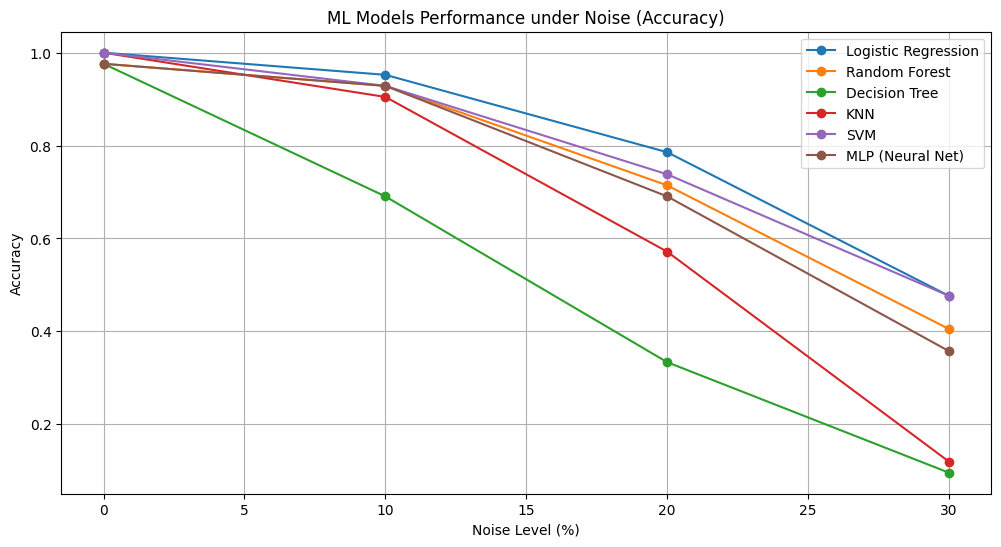

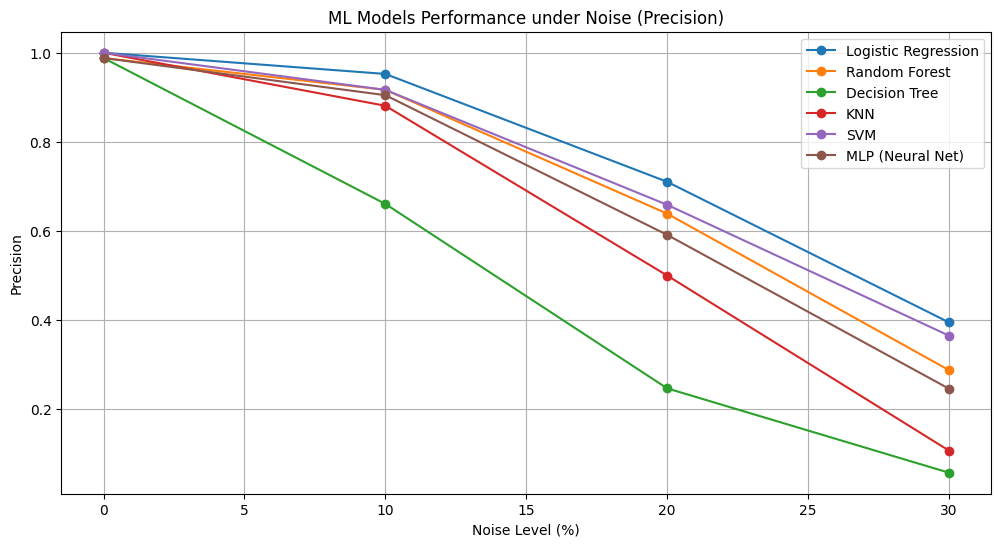

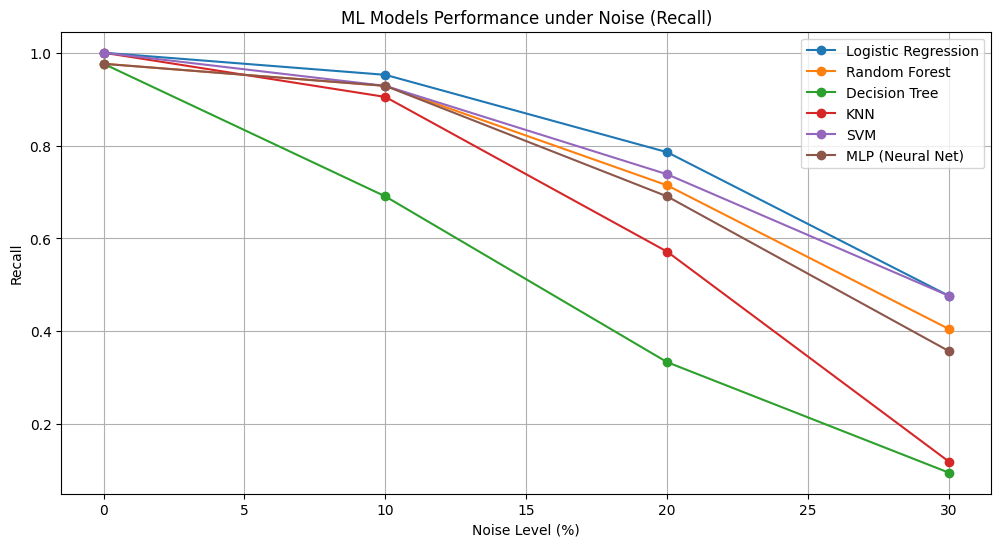

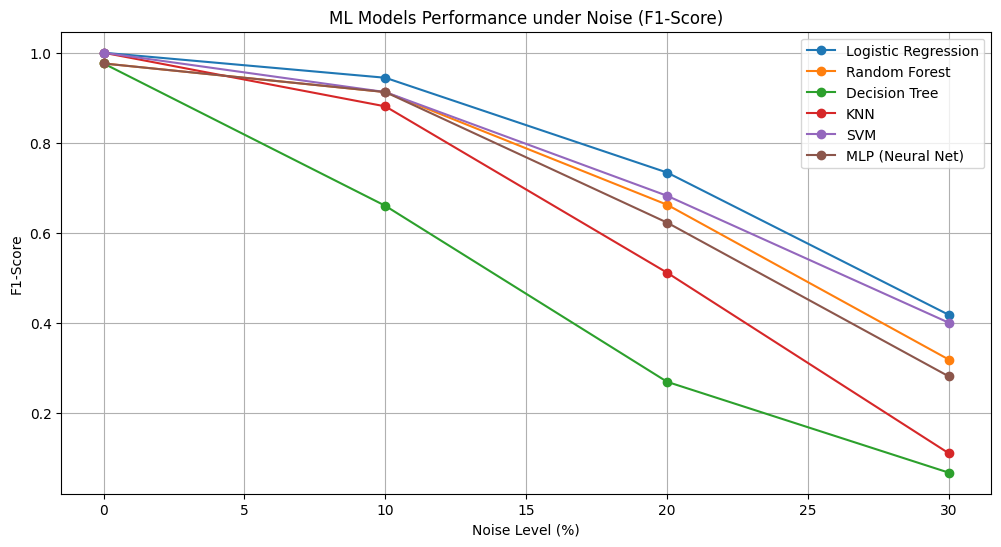

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --------------------------
# Load Data
# --------------------------
train_df = pd.read_csv("training_data.csv")
test_df = pd.read_csv("test_data.csv")

label_col = "prognosis"

X_train = train_df.drop(columns=[label_col])
y_train = train_df[label_col]

X_test = test_df.drop(columns=[label_col])
y_test = test_df[label_col]

# --------------------------
# Align train and test columns
# --------------------------
X_train_cols = X_train.columns
X_test = X_test.reindex(columns=X_train_cols, fill_value=0)  # add missing columns as 0

# --------------------------
# Noise Injection Function (Safe)
# --------------------------
def inject_feature_noise(X, noise_level=0.1, random_state=42):
    np.random.seed(random_state)
    X_noisy = X.fillna(0).astype(float).to_numpy()
    n_samples, n_features = X_noisy.shape
    n_noisy = int(noise_level * n_samples * n_features)

    rows = np.random.randint(0, n_samples, n_noisy)
    cols = np.random.randint(0, n_features, n_noisy)

    X_noisy[rows, cols] = 1 - X_noisy[rows, cols]
    return X_noisy

# --------------------------
# Define Models
# --------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel="rbf", probability=True),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500, random_state=42)
}


# --------------------------
# Run Experiments
# --------------------------
noise_levels = [0.0, 0.1, 0.2, 0.3]
results = []

for nl in noise_levels:
    print(f"\n==============================")
    print(f" Running with {int(nl*100)}% Feature Noise ")
    print("==============================")

    X_train_noisy = inject_feature_noise(X_train, noise_level=nl)
    X_test_noisy  = inject_feature_noise(X_test, noise_level=nl)

    for name, model in models.items():
        model.fit(X_train_noisy, y_train)
        y_pred = model.predict(X_test_noisy)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        print(f"{name} | Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

        results.append([nl, name, acc, prec, rec, f1])


# --------------------------
# Save Results
# --------------------------
results_df = pd.DataFrame(results, columns=["Noise", "Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print("\nFinal Results Table:")
print(results_df)

# --------------------------
# Visualization
# --------------------------
for metric in ["Accuracy", "Precision", "Recall", "F1-Score"]:
    plt.figure(figsize=(12,6))
    for model_name in results_df["Model"].unique():
        subset = results_df[results_df["Model"] == model_name]
        plt.plot(subset["Noise"]*100, subset[metric], marker="o", label=model_name)
    plt.xlabel("Noise Level (%)")
    plt.ylabel(metric)
    plt.title(f"ML Models Performance under Noise ({metric})")
    plt.legend()
    plt.grid(True)
    plt.show()


In [73]:
import warnings, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

# ==========================
# 0. Load Data
# ==========================
train_df = pd.read_csv("training_data.csv")
test_df  = pd.read_csv("test_data.csv")

label_col = "prognosis"
X_train = train_df.drop(columns=[label_col]).fillna(0).astype(float)
y_train = train_df[label_col]
X_test  = test_df.drop(columns=[label_col]).fillna(0).astype(float)
y_test  = test_df[label_col]

# Ensure columns match
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encode labels for prediction later
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# ==========================
# 1. Noise Injection Function
# ==========================
def inject_feature_noise(X, noise_level=0.3, random_state=42):
    np.random.seed(random_state)
    X_noisy = X.copy().values  # convert to numpy
    n_samples, n_features = X_noisy.shape
    n_noisy = int(noise_level * n_samples * n_features)
    rows = np.random.randint(0, n_samples, n_noisy)
    cols = np.random.randint(0, n_features, n_noisy)
    X_noisy[rows, cols] = 1 - X_noisy[rows, cols]  # flip 0<->1
    return X_noisy

# Inject 30% noise
X_train_noisy = inject_feature_noise(X_train, noise_level=0.3)
X_test_noisy  = inject_feature_noise(X_test, noise_level=0.3)

# ==========================
# 2. Define ML Models
# ==========================
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
}

# ==========================
# 3. Fit models on noisy data
# ==========================
for name, model in models.items():
    model.fit(X_train_noisy, y_train_enc)

# ==========================
# 4. User Symptom Input
# ==========================
symptoms_list = X_train.columns.tolist()
user_symptoms = []

print("\nEnter symptoms one by one. Type 'done' to finish.\n")
while True:
    symptom = input("Enter symptom: ").strip().lower()
    if symptom == "done":
        break
    if symptom not in [s.lower() for s in symptoms_list]:
        print("Unknown symptom. Try again.")
        continue
    if symptom in user_symptoms:
        print("Already added.")
        continue
    user_symptoms.append(symptom)
    print(f"Current symptoms: {user_symptoms}")

# Convert to feature vector
user_vector = np.zeros(len(symptoms_list))
for s in user_symptoms:
    idx = [i for i, sym in enumerate(symptoms_list) if sym.lower() == s][0]
    user_vector[idx] = 1

# Inject 30% noise to user input as well
user_vector_noisy = user_vector.copy()
n_features = len(user_vector_noisy)
n_noisy = int(0.3 * n_features)
np.random.seed(42)
flip_indices = np.random.choice(n_features, n_noisy, replace=False)
user_vector_noisy[flip_indices] = 1 - user_vector_noisy[flip_indices]

# ==========================
# 5. Predict with all models and time
# ==========================
print("\n===== PREDICTION WITH NOISE (30%) =====\n")
for name, model in models.items():
    start_time = time.time()
    pred_enc = model.predict([user_vector_noisy])[0]
    end_time = time.time()
    pred_disease = le.inverse_transform([pred_enc])[0]
    print(f"{name} → Predicted Disease: {pred_disease} | Time Taken: {end_time - start_time:.6f} sec")




Enter symptoms one by one. Type 'done' to finish.



Enter symptom:  vomiting


Current symptoms: ['vomiting']


Enter symptom:  breathlessness


Current symptoms: ['vomiting', 'breathlessness']


Enter symptom:  chest_pain


Current symptoms: ['vomiting', 'breathlessness', 'chest_pain']


Enter symptom:  sweating


Current symptoms: ['vomiting', 'breathlessness', 'chest_pain', 'sweating']


Enter symptom:  done



===== PREDICTION WITH NOISE (30%) =====

Decision Tree → Predicted Disease: Arthritis | Time Taken: 0.001469 sec
Random Forest → Predicted Disease: Arthritis | Time Taken: 0.007162 sec
Logistic Regression → Predicted Disease: Psoriasis | Time Taken: 0.000000 sec
SVM → Predicted Disease: Arthritis | Time Taken: 0.002308 sec
KNN → Predicted Disease: AIDS | Time Taken: 0.005179 sec
MLP (Neural Net) → Predicted Disease: Psoriasis | Time Taken: 0.000000 sec


Imported libraries
Dimensionality Reduction (TruncatedSVD)
Projected Graph: 4962 nodes, 12308241 edges

🔹 Training GCN with 10% noise...
Epoch 50/200 - Loss: 0.1406
Epoch 100/200 - Loss: 0.0967
Epoch 150/200 - Loss: 0.0927
Epoch 200/200 - Loss: 0.0794

🔹 Training GraphSAGE with 10% noise...
Epoch 50/200 - Loss: 0.0784
Epoch 100/200 - Loss: 0.0609
Epoch 150/200 - Loss: 0.0544
Epoch 200/200 - Loss: 0.0499

🔹 Training GAT with 10% noise...
Epoch 50/200 - Loss: 0.1061
Epoch 100/200 - Loss: 0.0540
Epoch 150/200 - Loss: 0.0469
Epoch 200/200 - Loss: 0.0452

🔹 Training GCN with 20% noise...
Epoch 50/200 - Loss: 0.1856
Epoch 100/200 - Loss: 0.1197
Epoch 150/200 - Loss: 0.1023
Epoch 200/200 - Loss: 0.0966

🔹 Training GraphSAGE with 20% noise...
Epoch 50/200 - Loss: 0.1502
Epoch 100/200 - Loss: 0.0925
Epoch 150/200 - Loss: 0.0742
Epoch 200/200 - Loss: 0.0771

🔹 Training GAT with 20% noise...
Epoch 50/200 - Loss: 0.1850
Epoch 100/200 - Loss: 0.0737
Epoch 150/200 - Loss: 0.0620
Epoch 200/200 - Loss

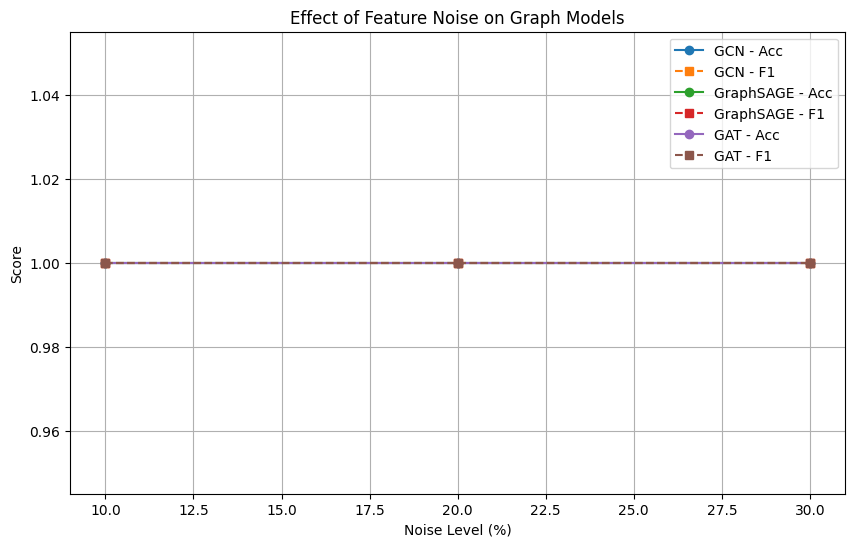

In [69]:
# ===============================
# 0. Imports
# ===============================
!pip install torch-geometric --quiet

import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

print("Imported libraries")

# ===============================
# 1. Load Data
# ===============================
train_df = pd.read_csv("training_data.csv")
test_df  = pd.read_csv("test_data.csv")

label_col = "prognosis"

X_train = train_df.drop(columns=[label_col])
y_train = train_df[label_col]
X_test  = test_df.drop(columns=[label_col])
y_test  = test_df[label_col]

# ===============================
# 1a. Preprocess: Fill NaNs & Align Features
# ===============================
X_train = X_train.fillna(0).astype(float)
X_test  = X_test.fillna(0).astype(float)
# Ensure same columns in test as train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# ===============================
# 2. Dimensionality Reduction
# ===============================
print("Dimensionality Reduction (TruncatedSVD)")
svd = TruncatedSVD(n_components=min(32, X_train.shape[1]), random_state=42)
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced  = svd.transform(X_test)

# ===============================
# 3. Build Bipartite Graph (train + test)
# ===============================
patients_train = [f"p_{i}" for i in range(len(X_train_reduced))]
patients_test  = [f"q_{i}" for i in range(len(X_test_reduced))]
all_patients   = patients_train + patients_test
symptoms = [f"s_{i}" for i in range(X_train_reduced.shape[1])]

B = nx.Graph()
B.add_nodes_from(all_patients, bipartite=0)
B.add_nodes_from(symptoms, bipartite=1)

# Connect train nodes
for i, row in enumerate(X_train_reduced):
    present_features = np.where(row > 0)[0]
    B.add_edges_from([(f"p_{i}", f"s_{f}") for f in present_features])

# Connect test nodes
for i, row in enumerate(X_test_reduced):
    present_features = np.where(row > 0)[0]
    B.add_edges_from([(f"q_{i}", f"s_{f}") for f in present_features])

# Project to patient–patient graph
P = bipartite.weighted_projected_graph(B, all_patients)
print(f"Projected Graph: {P.number_of_nodes()} nodes, {P.number_of_edges()} edges")

# ===============================
# 4. Sparsify Graph (Top-k neighbors)
# ===============================
k = 5
edges_to_keep = []
for node in P.nodes():
    neighbors = P[node]
    if len(neighbors) > 0:
        sorted_neighbors = sorted(neighbors.items(), key=lambda x: x[1]['weight'], reverse=True)[:k]
        edges_to_keep.extend([(node, n) for n, attr in sorted_neighbors])

G_sparse = nx.Graph()
G_sparse.add_nodes_from(P.nodes())
for u, v in edges_to_keep:
    G_sparse.add_edge(u, v, weight=P[u][v]['weight'])

# ===============================
# 5. Node mapping and edge_index
# ===============================
node_mapping = {node: i for i, node in enumerate(G_sparse.nodes())}
num_nodes = len(G_sparse.nodes())

edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in G_sparse.edges()],
                          dtype=torch.long).t().contiguous()
edge_weight = torch.tensor([G_sparse.edges[u, v]["weight"] for u, v in G_sparse.edges()],
                           dtype=torch.float)

# ===============================
# 6. Node features
# ===============================
data_x = torch.stack(
    [torch.tensor(X_train_reduced[int(node.split('_')[1])], dtype=torch.float)
     if node.startswith('p_') else torch.tensor(X_test_reduced[int(node.split('_')[1])], dtype=torch.float)
     for node in G_sparse.nodes()]
)

# ===============================
# 6a. Feature Noise Injection
# ===============================
def inject_feature_noise_tensor(x, noise_level=0.2, seed=42):
    torch.manual_seed(seed)
    x_noisy = x.clone()
    n_nodes, n_feats = x_noisy.shape
    n_noisy = int(noise_level * n_nodes * n_feats)
    idx = torch.randint(0, n_nodes * n_feats, (n_noisy,))
    x_noisy.view(-1)[idx] = 1 - x_noisy.view(-1)[idx]  # flip bits
    return x_noisy

# ===============================
# 7. Labels & Masks
# ===============================
le = LabelEncoder()
y_all = np.concatenate([y_train.values, y_test.values])
y_all_enc = le.fit_transform(y_all)
data_y = torch.tensor(y_all_enc, dtype=torch.long)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)
for node in patients_train:
    train_mask[node_mapping[node]] = True
for node in patients_test:
    test_mask[node_mapping[node]]  = True

# ===============================
# 8. Graph Model
# ===============================
class GraphModel(torch.nn.Module):
    def __init__(self, model_type, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.model_type = model_type
        if model_type == "GCN":
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)
        elif model_type == "GraphSAGE":
            self.conv1 = SAGEConv(in_channels, hidden_channels)
            self.conv2 = SAGEConv(hidden_channels, out_channels)
        elif model_type == "GAT":
            self.conv1 = GATConv(in_channels, hidden_channels, heads=2, concat=True)
            self.conv2 = GATConv(hidden_channels*2, out_channels, heads=1)
        else:
            raise ValueError("Unknown model type")

    def forward(self, x, edge_index, edge_weight=None):
        if self.model_type == "GCN":
            x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index, edge_weight=edge_weight)
        else:  # GraphSAGE or GAT
            x = F.relu(self.conv1(x, edge_index))
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index)
        return x

# ===============================
# 9. Train & Evaluate Function
# ===============================
def train_evaluate(model, data_x, data_y, edge_index, edge_weight, train_mask, test_mask,
                   epochs=200, lr=0.01, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_x, edge_index, edge_weight)
        loss = criterion(out[train_mask], data_y[train_mask])
        loss.backward()
        optimizer.step()
        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        out = model(data_x, edge_index, edge_weight)
        pred = out[test_mask].argmax(dim=1).cpu().numpy()
        true = data_y[test_mask].cpu().numpy()

    acc  = accuracy_score(true, pred)
    prec = precision_score(true, pred, average="weighted", zero_division=0)
    rec  = recall_score(true, pred, average="weighted", zero_division=0)
    f1   = f1_score(true, pred, average="weighted", zero_division=0)

    return acc, prec, rec, f1

# ===============================
# 10. Run models at noise levels
# ===============================
feat_dim = data_x.shape[1]
num_classes = len(torch.unique(data_y))
hidden_dim = 64

noise_levels = [0.1, 0.2, 0.3]
all_results = []

for nl in noise_levels:
    noisy_x = inject_feature_noise_tensor(data_x, noise_level=nl)
    for model_type in ["GCN", "GraphSAGE", "GAT"]:
        print(f"\n🔹 Training {model_type} with {int(nl*100)}% noise...")
        model = GraphModel(model_type, feat_dim, hidden_dim, num_classes)
        acc, prec, rec, f1 = train_evaluate(model, noisy_x, data_y, edge_index, edge_weight, train_mask, test_mask)
        all_results.append({"Model": model_type, "Noise": int(nl*100),
                            "Acc": acc, "Prec": prec, "Rec": rec, "F1": f1})

results_df = pd.DataFrame(all_results)
print("\n📊 Results Table:")
print(results_df)

# ===============================
# 11. Plot performance
# ===============================
plt.figure(figsize=(10,6))
for model_type in ["GCN", "GraphSAGE", "GAT"]:
    subset = results_df[results_df["Model"] == model_type]
    plt.plot(subset["Noise"], subset["Acc"], marker="o", label=f"{model_type} - Acc")
    plt.plot(subset["Noise"], subset["F1"], marker="s", linestyle="--", label=f"{model_type} - F1")

plt.xlabel("Noise Level (%)")
plt.ylabel("Score")
plt.title("Effect of Feature Noise on Graph Models")
plt.legend()
plt.grid(True)
plt.show()


In [75]:
import warnings, time
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

# ==========================
# 0. Load Data & Preprocess
# ==========================
train_df = pd.read_csv("training_data.csv")
test_df  = pd.read_csv("test_data.csv")

label_col = "prognosis"
X_train = train_df.drop(columns=[label_col]).fillna(0).astype(float)
y_train = train_df[label_col]
X_test  = test_df.drop(columns=[label_col]).fillna(0).astype(float)
y_test  = test_df[label_col]

# Ensure same columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encode labels
le = LabelEncoder()
y_all_enc = le.fit_transform(pd.concat([y_train, y_test]))
num_classes = len(le.classes_)

# ==========================
# 1. Dimensionality Reduction
# ==========================
svd = TruncatedSVD(n_components=min(32, X_train.shape[1]), random_state=42)
X_train_red = svd.fit_transform(X_train)
X_test_red  = svd.transform(X_test)

# ==========================
# 2. Build Graph
# ==========================
patients_train = [f"p_{i}" for i in range(len(X_train_red))]
patients_test  = [f"q_{i}" for i in range(len(X_test_red))]
all_patients   = patients_train + patients_test
symptoms = [f"s_{i}" for i in range(X_train_red.shape[1])]

B = nx.Graph()
B.add_nodes_from(all_patients, bipartite=0)
B.add_nodes_from(symptoms, bipartite=1)

for i, row in enumerate(X_train_red):
    B.add_edges_from([(f"p_{i}", f"s_{f}") for f in np.where(row>0)[0]])
for i, row in enumerate(X_test_red):
    B.add_edges_from([(f"q_{i}", f"s_{f}") for f in np.where(row>0)[0]])

# Project to patient–patient graph and sparsify
P = bipartite.weighted_projected_graph(B, all_patients)
k = 5
edges_to_keep = []
for node in P.nodes():
    neighbors = P[node]
    if neighbors:
        topk = sorted(neighbors.items(), key=lambda x:x[1]['weight'], reverse=True)[:k]
        edges_to_keep.extend([(node,n) for n,_ in topk])

G_sparse = nx.Graph()
G_sparse.add_nodes_from(P.nodes())
for u,v in edges_to_keep:
    G_sparse.add_edge(u,v,weight=P[u][v]['weight'])

# Node mapping
node_mapping = {node:i for i,node in enumerate(G_sparse.nodes())}
num_nodes = len(G_sparse.nodes())

edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u,v in G_sparse.edges()],
                          dtype=torch.long).t().contiguous()
edge_weight = torch.tensor([G_sparse.edges[u,v]['weight'] for u,v in G_sparse.edges()], dtype=torch.float)

# ==========================
# 3. Node features + Noise
# ==========================
data_x = torch.stack([
    torch.tensor(X_train_red[int(node.split('_')[1])], dtype=torch.float)
    if node.startswith('p_') else torch.tensor(X_test_red[int(node.split('_')[1])], dtype=torch.float)
    for node in G_sparse.nodes()
])

def inject_noise(x, noise_level=0.3, seed=42):
    torch.manual_seed(seed)
    x_noisy = x.clone()
    n_nodes, n_feats = x.shape
    n_noisy = int(noise_level * n_nodes * n_feats)
    idx = torch.randint(0, n_nodes*n_feats, (n_noisy,))
    x_noisy.view(-1)[idx] = 1 - x_noisy.view(-1)[idx]
    return x_noisy

data_x_noisy = inject_noise(data_x, noise_level=0.3)

# ==========================
# 4. Labels & masks
# ==========================
data_y = torch.tensor(y_all_enc, dtype=torch.long)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)
for node in patients_train:
    train_mask[node_mapping[node]] = True
for node in patients_test:
    test_mask[node_mapping[node]] = True

# ==========================
# 5. Graph Models
# ==========================
class GraphModel(torch.nn.Module):
    def __init__(self, model_type, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.model_type = model_type
        if model_type=="GCN":
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)
        elif model_type=="GraphSAGE":
            self.conv1 = SAGEConv(in_channels, hidden_channels)
            self.conv2 = SAGEConv(hidden_channels, out_channels)
        elif model_type=="GAT":
            self.conv1 = GATConv(in_channels, hidden_channels, heads=2, concat=True)
            self.conv2 = GATConv(hidden_channels*2, out_channels, heads=1)

    def forward(self, x, edge_index, edge_weight=None):
        if self.model_type=="GCN":
            x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
            x = F.dropout(x,0.5,training=self.training)
            x = self.conv2(x, edge_index, edge_weight=edge_weight)
        else:
            x = F.relu(self.conv1(x, edge_index))
            x = F.dropout(x,0.5,training=self.training)
            x = self.conv2(x, edge_index)
        return x

def train_gnn(model, x, y, edge_index, edge_weight, train_mask, epochs=200, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(x, edge_index, edge_weight)
        loss = criterion(out[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()
    return model

# ==========================
# 6. User Symptom Input
# ==========================
symptoms_list = X_train.columns.tolist()
user_symptoms = []

print("\nEnter symptoms one by one. Type 'done' to finish.\n")
while True:
    s = input("Enter symptom: ").strip().lower()
    if s=="done": break
    if s not in [x.lower() for x in symptoms_list]:
        print("Unknown symptom. Try again."); continue
    if s in user_symptoms:
        print("Already added."); continue
    user_symptoms.append(s)
    print(f"Current symptoms: {user_symptoms}")

user_vec = np.zeros(len(symptoms_list))
for s in user_symptoms:
    idx = [i for i,sym in enumerate(symptoms_list) if sym.lower()==s][0]
    user_vec[idx] = 1

# Dimensionality reduction
user_vec_red = svd.transform([user_vec])
user_tensor = torch.tensor(user_vec_red, dtype=torch.float)
user_tensor_noisy = inject_noise(user_tensor, noise_level=0.3)

# Append to graph features
full_x = torch.cat([data_x_noisy, user_tensor_noisy], dim=0)
user_node_idx = full_x.shape[0]-1

# ==========================
# 7. Train & Predict for each GNN
# ==========================
gnn_models = ["GCN","GraphSAGE","GAT"]
hidden_dim = 64
results = []

for gnn_name in gnn_models:
    print(f"\n🔹 Training {gnn_name} and predicting...")
    model = GraphModel(gnn_name, full_x.shape[1], hidden_dim, num_classes)
    start_time = time.time()
    model = train_gnn(model, full_x[:-1], data_y, edge_index, edge_weight, train_mask)
    model.eval()
    with torch.no_grad():
        out = model(full_x, edge_index, edge_weight)
        pred_class = out[user_node_idx].argmax().item()
        disease = le.inverse_transform([pred_class])[0]
    end_time = time.time()
    print(f"{gnn_name} → Predicted Disease: {disease} | Time: {end_time-start_time:.4f} sec")
    results.append((gnn_name, disease, end_time-start_time))



Enter symptoms one by one. Type 'done' to finish.



Enter symptom:  vomiting


Current symptoms: ['vomiting']


Enter symptom:  sunken_eyes


Current symptoms: ['vomiting', 'sunken_eyes']


Enter symptom:  dehydration


Current symptoms: ['vomiting', 'sunken_eyes', 'dehydration']


Enter symptom:  diarrhoea


Current symptoms: ['vomiting', 'sunken_eyes', 'dehydration', 'diarrhoea']


Enter symptom:  done



🔹 Training GCN and predicting...
GCN → Predicted Disease: Malaria | Time: 4.2333 sec

🔹 Training GraphSAGE and predicting...
GraphSAGE → Predicted Disease: Gastroenteritis | Time: 2.8095 sec

🔹 Training GAT and predicting...
GAT → Predicted Disease: Malaria | Time: 9.0401 sec
